# Advent of Code - 2021

## Daily Data

The input data for each day "e.g. day 5" should be downloaded into the data subdirectory for the corresponding day (e.g. data/day_5/input.txt). This will allow use of the `get_daily_data` generator function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

## Support Functions

In [2]:
import os
def get_daily_data(day, sep=None):
    daily_filename = "data/day_{}/input.txt".format(day)
    if not os.path.exists(daily_filename):
        try:
            os.rename("/Users/mikes/Downloads/input.txt", daily_filename)
        except:
            raise Exception("Could not find daily input file.")
    with open(daily_filename, 'r') as fin:
        for line in fin.readlines():
            if sep is None:
                yield line.rstrip()
            else:
                yield line.rstrip().split(sep)

## Day 5

In [375]:
example_data = ["0,9 -> 5,9","8,0 -> 0,8","9,4 -> 3,4","2,2 -> 2,1","7,0 -> 7,4","6,4 -> 2,0","0,9 -> 2,9","3,4 -> 1,4","0,0 -> 8,8","5,5 -> 8,2"]

In [262]:
def parse_coordinates(line):
    row = line.split()
    coords = row[0].split(',') + row[2].split(',')
    coords = [int(c) for c in coords]
    return coords

In [379]:
class SeaVents:
    
    def __init__(self, lines):
        self.lines = np.array(lines, dtype=int)
        # Note that the vents matrix is transposed
        # The x coordinate is the row and the y coordinate is the column
        max_x = max(self.lines[:, 0].max(), self.lines[:, 2].max())
        max_y = max(self.lines[:, 1].max(), self.lines[:, 3].max())
        self.vents = np.zeros((max_x + 1, max_y + 1))
        
    def map_vents(self, diagonals=False):
        n_h = 0
        n_v = 0
        n_d = 0
        for line in self.lines:
            source = [line[0], line[1]]
            target = [line[2], line[3]]
            
            # Record vent at source (NOT target)
            
            
            dx = source[0] - target[0]
            dy = source[1] - target[1]
            
            # Record vents between source and target
            if dx == 0:
                self.vents[source[0], source[1]] += 1
                n_v += 1
                while dy > 0:
                    source[1] -= 1
                    self.vents[source[0], source[1]] += 1
                    dy -= 1
                while dy < 0:
                    source[1] += 1
                    self.vents[source[0], source[1]] += 1
                    dy += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
            elif dy == 0:
                self.vents[source[0], source[1]] += 1
                n_h += 1
                while dx > 0:
                    source[0] -= 1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                while dx < 0:
                    source[0] += 1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
            elif diagonals:
                self.vents[source[0], source[1]] += 1
                n_d += 1
                while dx > 0 and dy > 0:
                    source[0] -= 1
                    source[1] -=1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                    dy -= 1
                while dx > 0 and dy < 0:
                    source[0] -= 1
                    source[1] +=1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                    dy += 1
                while dx < 0 and dy > 0:
                    source[0] += 1
                    source[1] -=1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                    dy -= 1
                while dx < 0 and dy < 0:
                    source[0] += 1
                    source[1] +=1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                    dy += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
        print("Drew {} horizontal, {} vertical, and {} diagonal lines.".format(n_h, n_v, n_d))
                    
    def n_danger_zones(self):
        return (self.vents > 1).sum()
    
    def plot_vents(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        ax[0].imshow(self.vents.T, cmap='Greys')
        ax[1].imshow((self.vents.T > 1), cmap='binary')
        for x in ax:
            x.set_xticks([])
            x.set_yticks([])
        sns.despine(bottom=True, left=True)

Drew 4 horizontal, 2 vertical, and 0 diagonal lines.


5

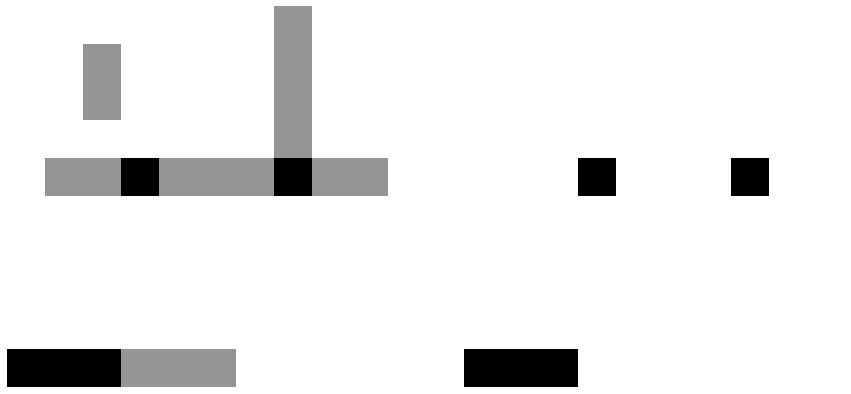

In [380]:
# Example input
data = [parse_coordinates(line) for line in example_data]
sv = SeaVents(data)
sv.map_vents()
sv.plot_vents()
sv.n_danger_zones()

Drew 175 horizontal, 166 vertical, and 0 diagonal lines.


6283

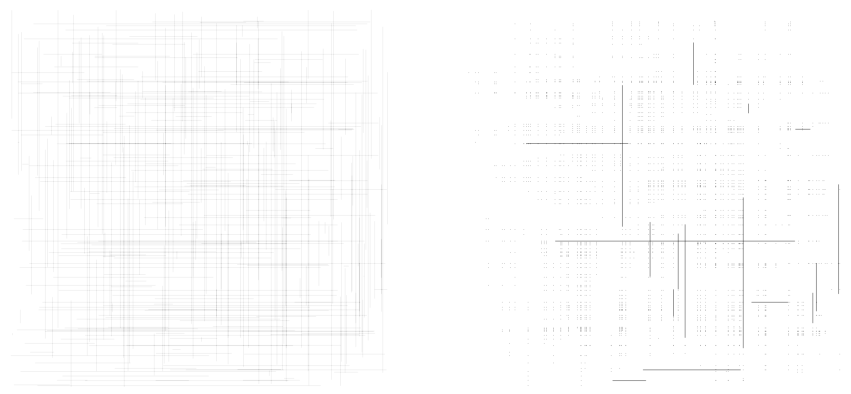

In [381]:
data = [parse_coordinates(line) for line in get_daily_data(5)]
sv = SeaVents(data)
sv.map_vents()
sv.plot_vents()
sv.n_danger_zones()

In [366]:
# 6621 too high

Drew 175 horizontal, 166 vertical, and 159 diagonal lines.


18864

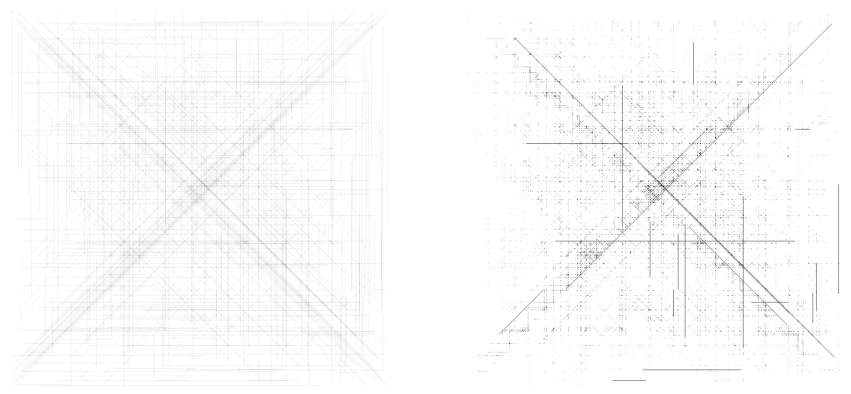

In [382]:
data = [parse_coordinates(line) for line in get_daily_data(5)]
sv = SeaVents(data)
sv.map_vents(diagonals=True)
sv.plot_vents()
sv.n_danger_zones()

## Day 4

In [3]:
class BingoBoard:
    
    def __init__(self, values):
        self.values = np.array(values)
        self.marked = np.zeros(self.values.shape).astype(bool)
        
    def mark(self, value):
        idx = np.where(self.values == value)
        self.marked[idx] = True
    
    def bingo(self):
        row_bingo = (self.marked.sum(axis=1) == self.marked.shape[0]).any()
        col_bingo = (self.marked.sum(axis=0) == self.marked.shape[1]).any()
        return row_bingo or col_bingo
        
    def get_unmarked_values(self):
        unmarked = ~self.marked
        return self.values[np.where(unmarked)]

In [4]:
def init_data():
    data = [line for line in get_daily_data(4)]
    balls = [int(x) for x in data.pop(0).split(',')]
    data.pop(0)  # throw away empty line

    boards = []
    board_values = []
    for line in data:
        if line == "":
            boards.append(BingoBoard(board_values))
            board_values = []
        else:
            row = [int(x) for x in line.split()]
            board_values.append(row)
    return boards, balls

In [5]:
def play_bingo(boards, balls):
    for bl in balls:
        for bd in boards:
            bd.mark(bl)
            if bd.bingo():
                solution = bd.get_unmarked_values().sum() * bl
                return solution

In [6]:
boards, balls = init_data()
play_bingo(boards, balls)

87456

In [7]:
def play_bad_bingo(boards, balls):
    for bl in balls:
        purge = []
        for bd in boards:
            bd.mark(bl)
            if bd.bingo():
                if len(boards) == 1:
                    solution = bd.get_unmarked_values().sum() * bl
                    return solution
                else:
                    purge.append(bd)
        for bd in purge:
            boards.remove(bd)

In [8]:
boards, balls = init_data()
play_bad_bingo(boards, balls)

15561

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

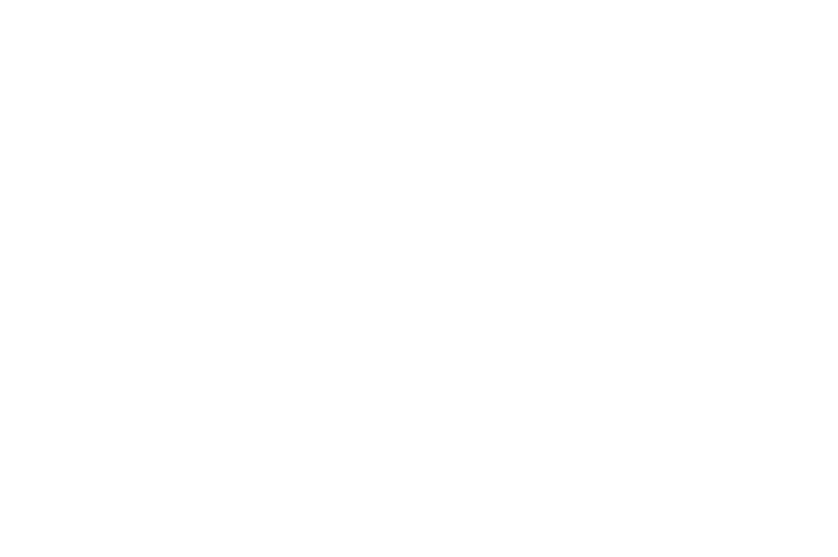

In [25]:
# TODO: Render these on each round of bingo to show how it plays out.
boards, balls = init_data()
fig, ax = plt.subplots(9, 11, figsize=(15, 10))
for i in range(9):
    for j in range(11):
        board = boards[i * 9 + j]
        ax[i][j].imshow(board.marked.astype(int), cmap='binary')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
sns.despine(bottom=True, left=True)
plt.show()

In [ ]:
raise

## Day 3

In [ ]:
def to_decimal(binary_vector):
    total = 0
    for pos, bit in enumerate(binary_vector[::-1]):
        total += bit * (2 ** pos)
    return total

In [ ]:
import numpy as np
from scipy import stats

data = []
for line in get_daily_data(3):
    data.append([int(x) for x in list(line.strip())])
data = np.array(data)

In [ ]:
gamma_bin = list(stats.mode(data, axis=0)[0][0])
epsilon_bin = [abs(data - 1) for data in gamma_bin]
gamma = to_decimal(gamma_bin)
epsilon = to_decimal(epsilon_bin)
gamma * epsilon

In [ ]:
def most_common(vec):
    n1 = sum(vec)
    n0 = len(vec) - sum(vec)
    if n0 == n1:
        return 1
    elif n0 > n1:
        return 0
    else:
        return 1

In [ ]:
def least_common(vec):
    n1 = sum(vec)
    n0 = len(vec) - sum(vec)
    if n0 == n1:
        return 0
    elif n0 > n1:
        return 1
    else:
        return 0

In [ ]:
def find_og_rating(data):
    for col in range(data.shape[1]):
        x = data[:, col]
        mode = most_common(x)
        data = data[x == mode, :]
        if data.shape[0] == 1:
            break
    assert(data.shape[0] == 1)
    return to_decimal(data[0, :])

In [ ]:
def find_co2_rating(data):
    for col in range(data.shape[1]):
        x = data[:, col]
        antimode = least_common(x)
        data = data[x == antimode, :]
        if data.shape[0] == 1:
            break
    assert(data.shape[0] == 1)
    return to_decimal(data[0, :])

In [ ]:
og = find_og_rating(data)
og

In [ ]:
co2 = find_co2_rating(data)
co2

In [ ]:
og * co2

In [ ]:
# 7105014 is too high

## Day 2

In [ ]:
horizontal_loc = 0
depth_loc = 0
for direction, value in get_daily_data(2, ' '):
    value = int(value)
    if direction == "forward":
        horizontal_loc += value
    elif direction == "down":
        depth_loc += value
    elif direction == "up":
        depth_loc -= value
horizontal_loc * depth_loc

In [ ]:
horizontal_loc = 0
depth_loc = 0
aim = 0
for direction, value in get_daily_data(2, ' '):
    value = int(value)
    if direction == "forward":
        horizontal_loc += value
        depth_loc += value * aim
    elif direction == "down":
        aim += value
    elif direction == "up":
        aim -= value
horizontal_loc * depth_loc

## Day 1

In [ ]:
n_increases = 0
prev_x = 9e32
for value in get_daily_data(1):
        x = int(value)
        if x > prev_x:
            n_increases += 1
        prev_x = x
n_increases

In [ ]:
n_increases = 0
window = []
prev_sum = None
for value in get_daily_data(1):
    x = int(value)
    if len(window) < 3:
        window.append(x)
    if prev_sum is None:
        prev_sum = sum(window)
    if len(window) == 3:
        window.pop(0)
        window.append(x)
        new_sum = sum(window)
        if new_sum > prev_sum:
            n_increases += 1
        prev_sum = new_sum
n_increases